In [4]:
import pandas as pd

左边界: 807.52
右边界: 810.46


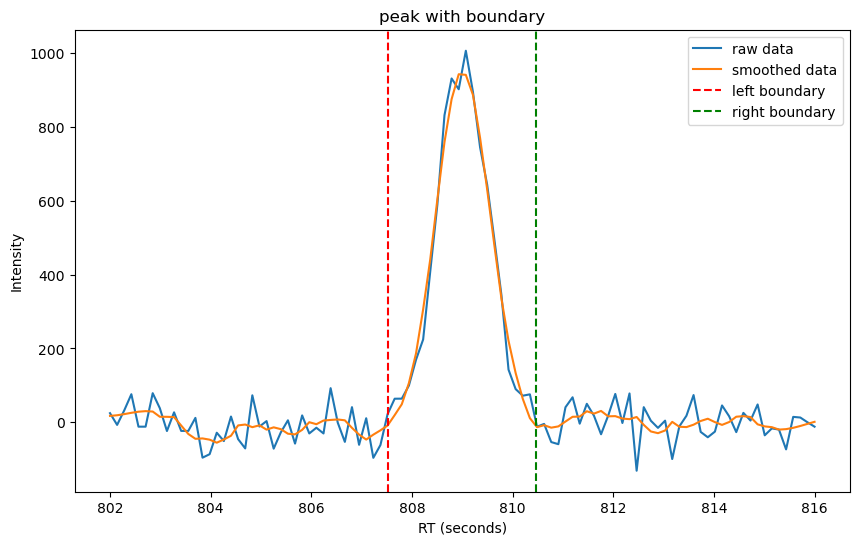

In [54]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

def find_peak_boundaries_improved(rt, intensity, prominence_threshold=0.5, min_peak_width=5, height_percentage=0.1):
    # 平滑数据
    smoothed_intensity = savgol_filter(intensity, window_length=5, polyorder=3)

    # 找到主峰
    peaks, properties = find_peaks(smoothed_intensity, prominence=prominence_threshold, width=min_peak_width)
    if len(peaks) == 0:
        return None, None
    main_peak = peaks[np.argmax(smoothed_intensity[peaks])]

    # 计算峰高
    peak_height = smoothed_intensity[main_peak] - np.min(smoothed_intensity)
    threshold_height = np.min(smoothed_intensity) + peak_height * height_percentage

    # 使用插值来获得更精确的边界
    f = interp1d(rt, smoothed_intensity, kind='cubic')
    rt_fine = np.linspace(rt[0], rt[-1], num=1000)
    intensity_fine = f(rt_fine)

    # 找到左边界
    left_idx = np.where(rt_fine < rt[main_peak])[0][-1]
    while left_idx > 0 and intensity_fine[left_idx] > threshold_height:
        left_idx -= 1

    # 找到右边界
    right_idx = np.where(rt_fine > rt[main_peak])[0][0]
    while right_idx < len(intensity_fine) - 1 and intensity_fine[right_idx] > threshold_height:
        right_idx += 1

    return rt_fine[left_idx], rt_fine[right_idx]

# 示例使用
rt = np.linspace(802, 816, 100)  # 保留时间
np.random.seed(42)  # 设置随机种子以确保结果可重现
intensity = np.random.normal(0, 50, 100)  # 增加噪声
intensity += 1000 * np.exp(-0.5 * ((rt - 809) / 0.5)**2)  # 模拟峰

left_boundary, right_boundary = find_peak_boundaries_improved(rt, intensity)
if left_boundary is not None and right_boundary is not None:
    print(f"左边界: {left_boundary:.2f}")
    print(f"右边界: {right_boundary:.2f}")
else:
    print("未找到峰边界")

# 绘图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rt, intensity, label='raw data')
plt.plot(rt, savgol_filter(intensity, window_length=11, polyorder=3), label='smoothed data')
if left_boundary is not None and right_boundary is not None:
    plt.axvline(x=left_boundary, color='r', linestyle='--', label='left boundary')
    plt.axvline(x=right_boundary, color='g', linestyle='--', label='right boundary')
plt.xlabel('RT (seconds)')
plt.ylabel('Intensity')
plt.title('peak with boundary')
plt.legend()
plt.show()

In [9]:
def str_to_array(s):
    return np.fromstring(s, sep=',', dtype=float)


def load_feature_matrix(feature_matrix_file):
    feature_matrix = pd.read_csv(feature_matrix_file, float_precision="high")
    for col in ['chrom_RT', 'chrom_intensity', 'EIC_RT', 'EIC_intensity']:
        if col in feature_matrix.columns:
            feature_matrix[col] = feature_matrix[col].apply(str_to_array)
    return feature_matrix


In [55]:
def test(df):

    rt = df.iloc[0, -2]
    intensity = df.iloc[0, -1]
    
    left_boundary, right_boundary = find_peak_boundaries_improved(rt, intensity)
    if left_boundary is not None and right_boundary is not None:
        print(f"左边界: {left_boundary:.2f}")
        print(f"右边界: {right_boundary:.2f}")
    else:
        print("未找到峰边界")
    
    # 绘图
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(rt, intensity, label='raw data')
    plt.plot(rt, savgol_filter(intensity, window_length=11, polyorder=3), label='smoothed data')
    if left_boundary is not None and right_boundary is not None:
        plt.axvline(x=left_boundary, color='r', linestyle='--', label='left boundary')
        plt.axvline(x=right_boundary, color='g', linestyle='--', label='right boundary')
    plt.xlabel('RT (seconds)')
    plt.ylabel('Intensity')
    plt.title('peak with boundary')
    plt.legend()
    plt.show()

In [56]:
feature_matrix_file = "191017USXP001_PN.feature_matrix.csv"
df = load_feature_matrix(feature_matrix_file)

In [115]:
df_sub = df[df["feature_id"] == 4712689854556864570]

左边界: 97.53
右边界: 107.24


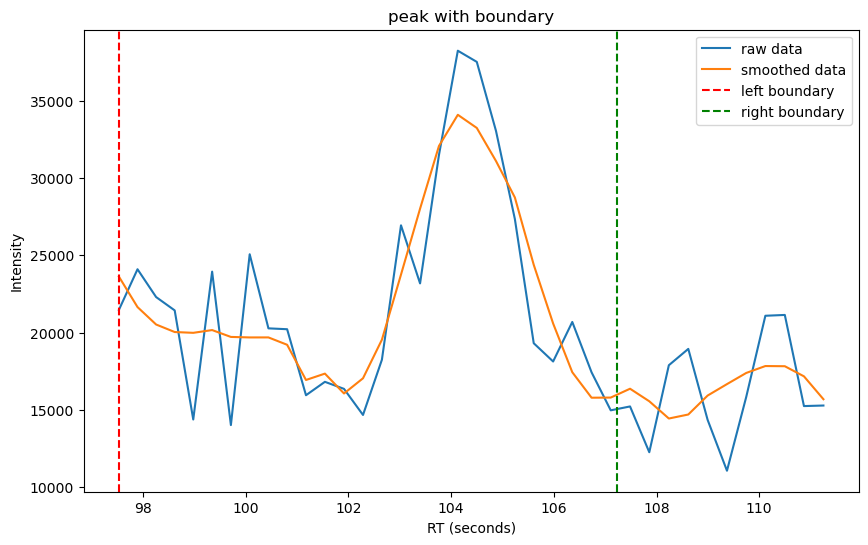

In [116]:
test(df_sub)

/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1784170780.py:84: UserWarning: Glyph 24179 (\N{CJK UN

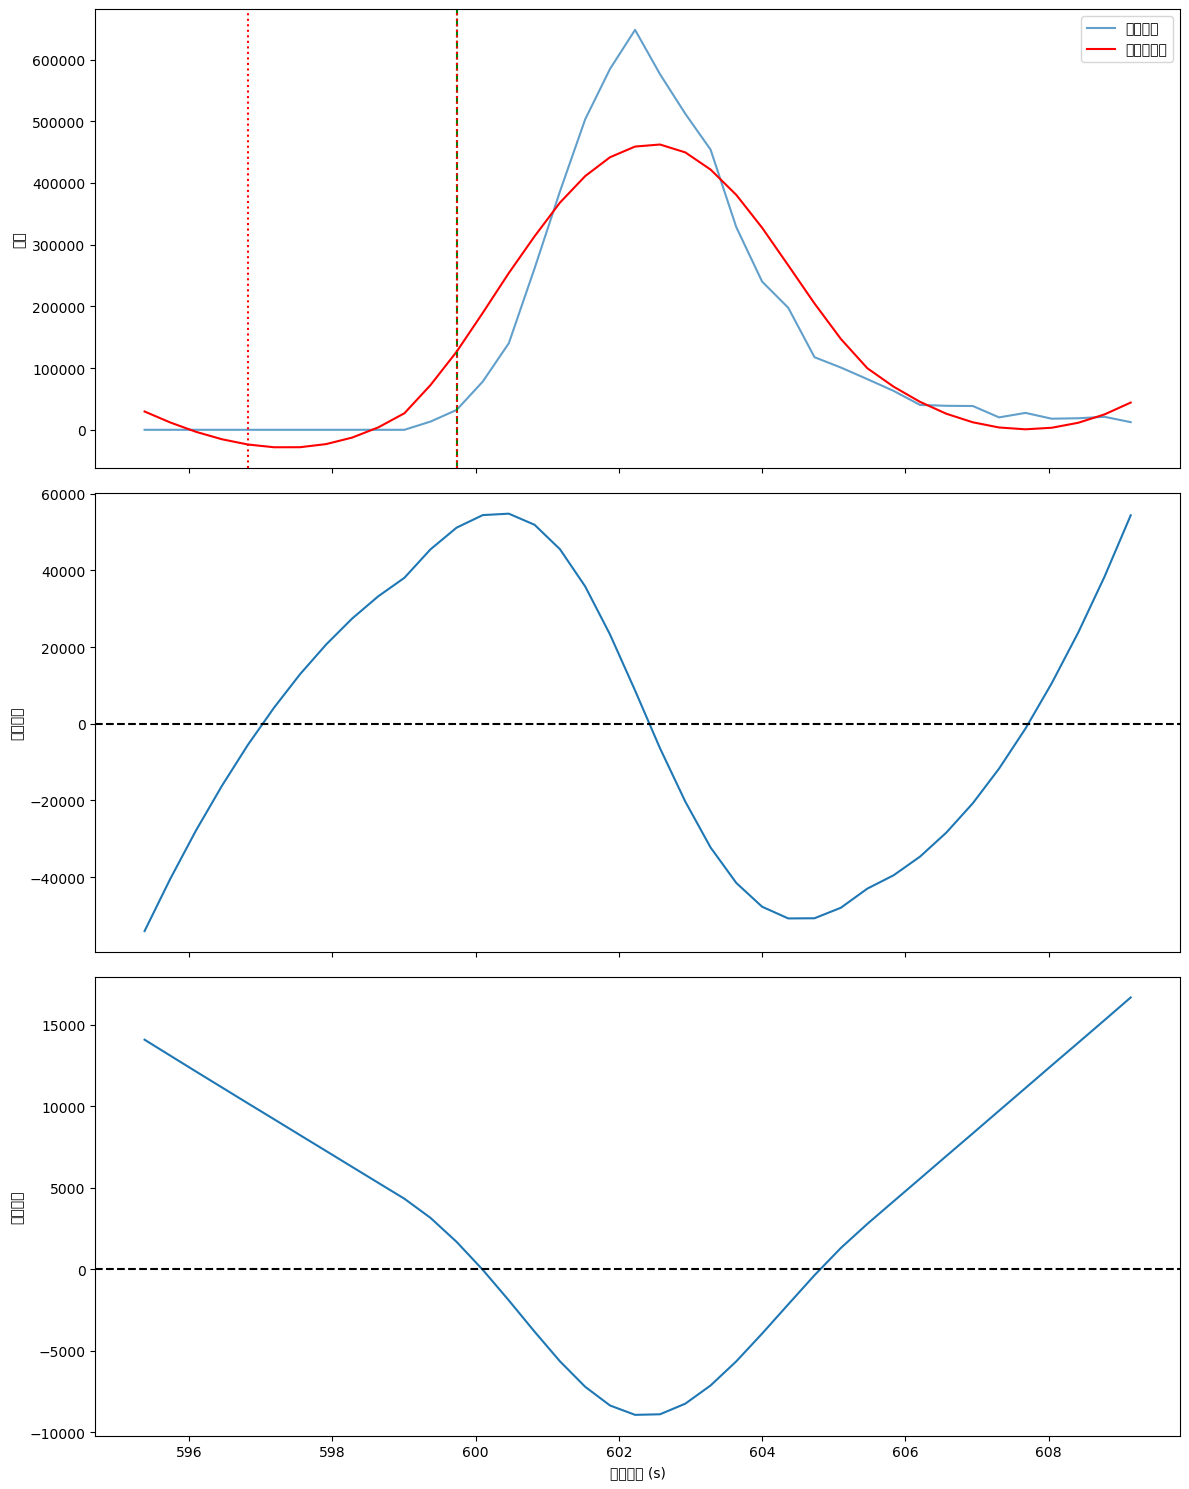

检测到的峰：
峰 1:
  峰顶位置: 599.73
  起始点: 596.82
  结束点: 599.73
  峰宽: 2.91
  峰高: 150306.12



In [77]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def find_peaks_sg(rt, intensity, window_length=5, polyorder=3, min_peak_width=5, max_peak_width=30.0, min_peak_height=100):
    # 应用 Savitzky-Golay 滤波器进行平滑处理
    smoothed = savgol_filter(intensity, window_length, polyorder)

    # 计算一阶和二阶导数
    first_derivative = savgol_filter(smoothed, window_length, polyorder, deriv=1)
    second_derivative = savgol_filter(smoothed, window_length, polyorder, deriv=2)

    # 找到二阶导数的零交叉点
    zero_crossings = np.where(np.diff(np.sign(second_derivative)))[0]

    # 在零交叉点周围找到局部负最小值作为峰顶点
    peaks = []
    for zc in zero_crossings:
        if zc > 0 and zc < len(second_derivative) - 1:
            if second_derivative[zc-1] > 0 and second_derivative[zc+1] < 0:
                peaks.append(zc)

    # 找到峰的起始和结束点（使用一阶导数），并应用峰宽和峰高限制
    valid_peaks = []
    valid_peak_boundaries = []
    for peak in peaks:
        left = peak
        while left > 0 and first_derivative[left] > 0:
            left -= 1

        right = peak
        while right < len(first_derivative) - 1 and first_derivative[right] < 0:
            right += 1

        peak_width = rt[right] - rt[left]
        peak_height = smoothed[peak] - min(smoothed[left], smoothed[right])

        if min_peak_width <= peak_width <= max_peak_width and peak_height >= min_peak_height:
            valid_peaks.append(peak)
            valid_peak_boundaries.append((left, right))

    return valid_peaks, valid_peak_boundaries, smoothed, first_derivative, second_derivative

# 生成示例数据
#rt = np.linspace(802, 816, 1000)
#np.random.seed(42)
#intensity = np.random.normal(0, 50, 1000)
#intensity += 1000 * np.exp(-0.5 * ((rt - 809) / 0.5)**2)  # 主峰
#intensity += 500 * np.exp(-0.5 * ((rt - 812) / 0.3)**2)   # 次峰
#intensity += 200 * np.exp(-0.5 * ((rt - 805) / 0.1)**2)   # 窄峰（可能是噪声）

rt = df_sub.iloc[0,-2]
intensity = df_sub.iloc[0,-1]

# 应用峰检测算法
peaks, peak_boundaries, smoothed, first_derivative, second_derivative = find_peaks_sg(
    rt, intensity, window_length=21, polyorder=3, min_peak_width=0.2, max_peak_width=5.0, min_peak_height=100
)

# 绘图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 原始数据和平滑后的数据
ax1.plot(rt, intensity, label='原始数据', alpha=0.7)
ax1.plot(rt, smoothed, label='平滑后数据', color='red')
for peak, (left, right) in zip(peaks, peak_boundaries):
    ax1.axvline(x=rt[peak], color='g', linestyle='--')
    ax1.axvline(x=rt[left], color='r', linestyle=':')
    ax1.axvline(x=rt[right], color='r', linestyle=':')
ax1.set_ylabel('强度')
ax1.legend()

# 一阶导数
ax2.plot(rt, first_derivative)
ax2.axhline(y=0, color='k', linestyle='--')
ax2.set_ylabel('一阶导数')

# 二阶导数
ax3.plot(rt, second_derivative)
ax3.axhline(y=0, color='k', linestyle='--')
ax3.set_ylabel('二阶导数')

plt.xlabel('保留时间 (s)')
plt.tight_layout()
plt.show()

# 打印结果
print("检测到的峰：")
for i, (peak, (left, right)) in enumerate(zip(peaks, peak_boundaries), 1):
    peak_width = rt[right] - rt[left]
    peak_height = smoothed[peak] - min(smoothed[left], smoothed[right])
    print(f"峰 {i}:")
    print(f"  峰顶位置: {rt[peak]:.2f}")
    print(f"  起始点: {rt[left]:.2f}")
    print(f"  结束点: {rt[right]:.2f}")
    print(f"  峰宽: {peak_width:.2f}")
    print(f"  峰高: {peak_height:.2f}")
    print()

In [73]:
df_sub.iloc[0,-2]

array([1044.23778, 1044.55626, 1044.87588, 1045.1949 , 1045.51224,
       1045.82952, 1046.14788, 1046.46588, 1046.78304, 1047.10014,
       1047.41916, 1047.73704, 1048.05354, 1048.37238, 1048.69062,
       1049.00826, 1049.3259 , 1049.64378, 1049.9613 , 1050.28002,
       1050.59916, 1050.91704, 1051.23588, 1051.554  , 1051.87164,
       1052.19054, 1052.50914, 1052.82918, 1053.14742, 1053.46638,
       1053.7854 , 1054.1043 , 1054.42356, 1054.74342, 1055.06406,
       1055.3853 , 1055.70678, 1056.02676, 1056.34668, 1056.66642,
       1056.98778, 1057.3089 , 1057.6329 , 1057.9578 ])

/tmp/ipykernel_1414229/4263008615.py:40: RuntimeWarning: invalid value encountered in double_scalars
  current_slope = (smoothed[left] - baseline_left) / (left - left)
/tmp/ipykernel_1414229/4263008615.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  current_slope = (smoothed[left] - baseline_left) / (left - left)
/tmp/ipykernel_1414229/4263008615.py:47: RuntimeWarning: invalid value encountered in double_scalars
  current_slope = (smoothed[right] - baseline_right) / (right - right)
/tmp/ipykernel_1414229/4263008615.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  current_slope = (smoothed[right] - baseline_right) / (right - right)


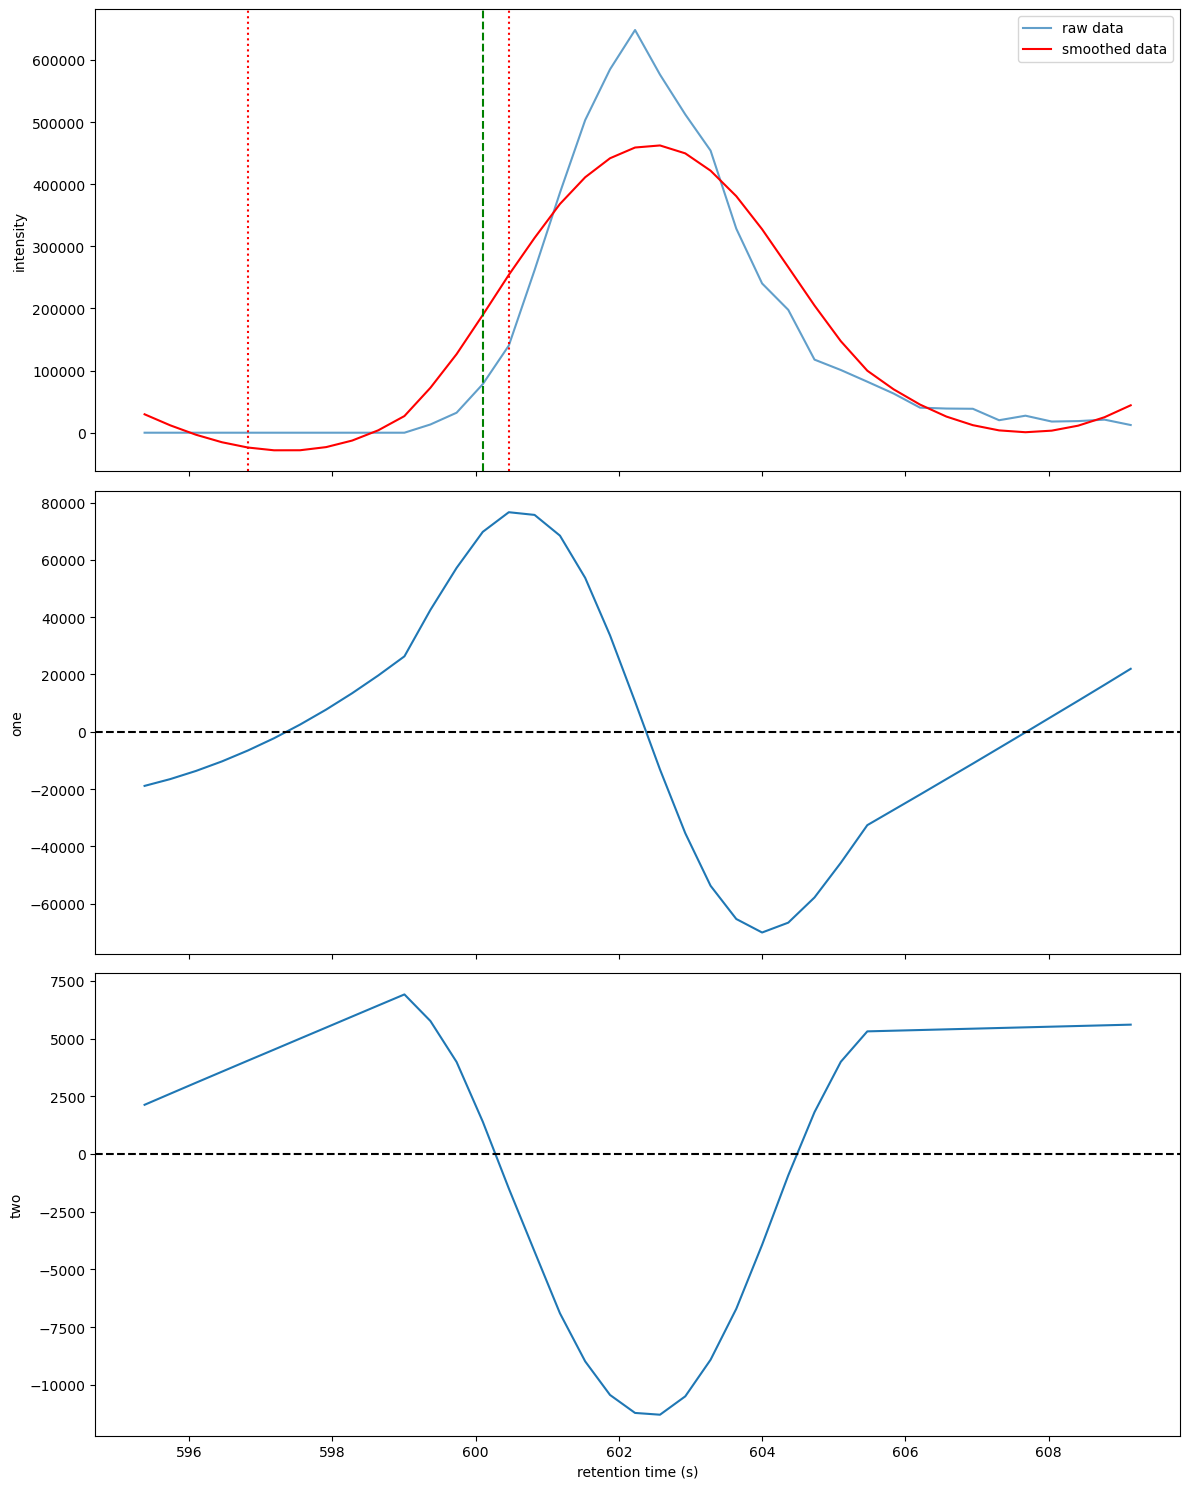

pead detected：
峰 1:
  峰顶位置: 600.10
  起始点: 596.82
  结束点: 600.46
  峰宽: 3.64
  峰高: 213354.99



In [80]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def find_peaks_improved(rt, intensity, window_length=21, polyorder=3, takeoff=0, landing=0.005):
    # 步骤1：提取EIC（在这个例子中，我们直接使用提供的intensity作为EIC）
    eic = intensity

    # 步骤2：使用Savitzky-Golay滤波器计算平滑的EIC及其一阶和二阶导数
    smoothed = savgol_filter(eic, window_length, polyorder)
    first_derivative = savgol_filter(eic, window_length, polyorder, deriv=1)
    second_derivative = savgol_filter(eic, window_length, polyorder, deriv=2)

    # 检测峰顶点
    zero_crossings = np.where(np.diff(np.sign(second_derivative)))[0]
    peaks = []
    for zc in zero_crossings:
        if zc > 0 and zc < len(second_derivative) - 1:
            if second_derivative[zc-1] > 0 and second_derivative[zc+1] < 0:
                peaks.append(zc)

    # 步骤3：使用改进的ApexTrack算法定位峰的边界
    peak_boundaries = []
    for peak in peaks:
        # 找到前部和尾部拐点
        left = peak
        while left > 0 and first_derivative[left] > 0:
            left -= 1
        right = peak
        while right < len(first_derivative) - 1 and first_derivative[right] < 0:
            right += 1

        # 计算初始基线
        baseline_left = smoothed[left]
        baseline_right = smoothed[right]
        initial_slope = (baseline_right - baseline_left) / (right - left)

        # 扩展左边界
        while left > 0:
            current_slope = (smoothed[left] - baseline_left) / (left - left)
            if abs(current_slope - initial_slope) / abs(initial_slope) > takeoff:
                break
            left -= 1

        # 扩展右边界
        while right < len(smoothed) - 1:
            current_slope = (smoothed[right] - baseline_right) / (right - right)
            if abs(current_slope - initial_slope) / abs(initial_slope) > landing:
                break
            right += 1

        peak_boundaries.append((left, right))

    return peaks, peak_boundaries, smoothed, first_derivative, second_derivative

# 生成示例数据
rt = df_sub.iloc[0,-2]
intensity = df_sub.iloc[0,-1]

# 应用改进的峰检测算法
peaks, peak_boundaries, smoothed, first_derivative, second_derivative = find_peaks_improved(rt, intensity)

# 绘图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 原始数据和平滑后的数据
ax1.plot(rt, intensity, label='raw data', alpha=0.7)
ax1.plot(rt, smoothed, label='smoothed data', color='red')
for peak, (left, right) in zip(peaks, peak_boundaries):
    ax1.axvline(x=rt[peak], color='g', linestyle='--')
    ax1.axvline(x=rt[left], color='r', linestyle=':')
    ax1.axvline(x=rt[right], color='r', linestyle=':')
ax1.set_ylabel('intensity')
ax1.legend()

# 一阶导数
ax2.plot(rt, first_derivative)
ax2.axhline(y=0, color='k', linestyle='--')
ax2.set_ylabel('one')

# 二阶导数
ax3.plot(rt, second_derivative)
ax3.axhline(y=0, color='k', linestyle='--')
ax3.set_ylabel('two')

plt.xlabel('retention time (s)')
plt.tight_layout()
plt.show()

# 打印结果
print("pead detected：")
for i, (peak, (left, right)) in enumerate(zip(peaks, peak_boundaries), 1):
    peak_width = rt[right] - rt[left]
    peak_height = smoothed[peak] - min(smoothed[left], smoothed[right])
    print(f"峰 {i}:")
    print(f"  峰顶位置: {rt[peak]:.2f}")
    print(f"  起始点: {rt[left]:.2f}")
    print(f"  结束点: {rt[right]:.2f}")
    print(f"  峰宽: {peak_width:.2f}")
    print(f"  峰高: {peak_height:.2f}")
    print()

/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1414229/1522702758.py:79: UserWarning: Glyph 24179 (\N{CJK UN

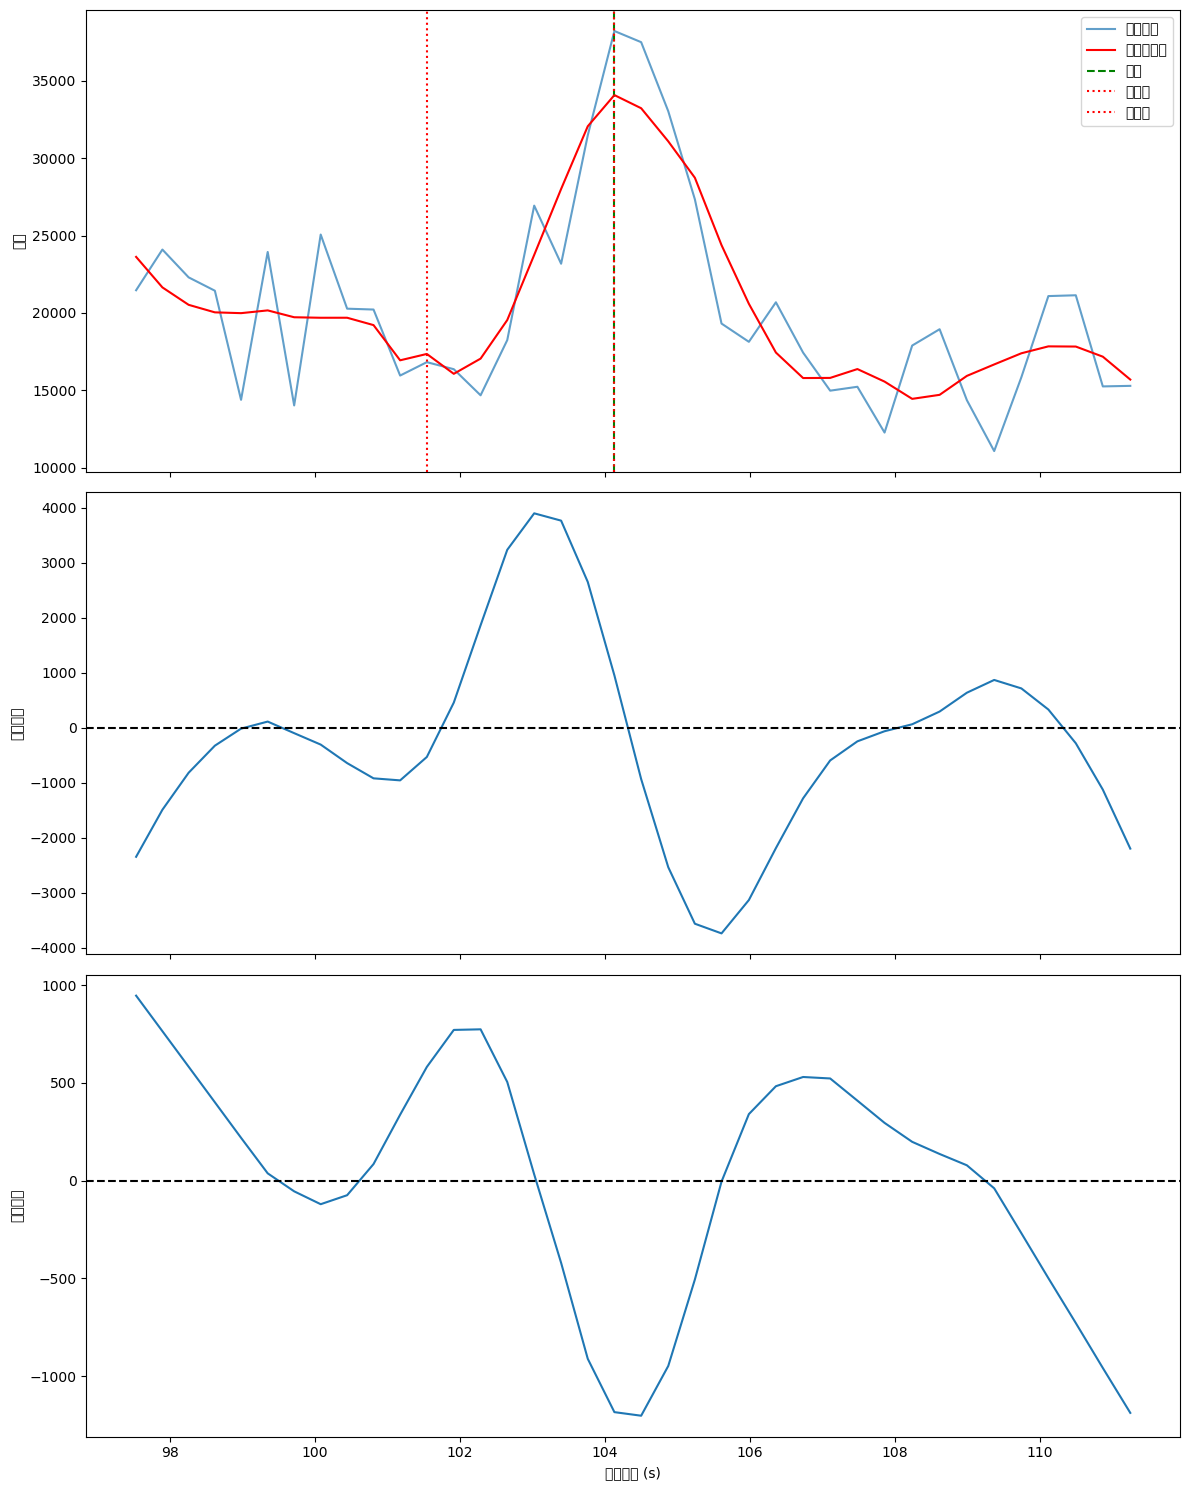

检测到的峰：
  峰顶位置: 104.13
  起始点: 101.54
  结束点: 104.13
  峰宽: 2.59
  峰高: 16735.00


In [117]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def find_peak_improved(rt, intensity, window_length=11, polyorder=3, snr_threshold=5, peak_width_threshold=5):
    # 平滑处理
    smoothed = savgol_filter(intensity, window_length, polyorder)

    # 计算噪声水平
    noise_level = np.std(intensity - smoothed)

    # 计算一阶和二阶导数
    first_derivative = savgol_filter(smoothed, window_length, polyorder, deriv=1)
    second_derivative = savgol_filter(smoothed, window_length, polyorder, deriv=2)

    # 找到潜在的峰顶
    peaks = np.where((smoothed[1:-1] > smoothed[:-2]) & (smoothed[1:-1] > smoothed[2:]))[0] + 1

    valid_peaks = []
    for peak in peaks:
        # 计算信噪比
        snr = (smoothed[peak] - np.min(smoothed)) / noise_level

        # 寻找左边界
        left = peak
        while left > 0 and first_derivative[left] > 0:
            left -= 1

        # 寻找右边界
        right = peak
        while right < len(smoothed) - 1 and first_derivative[right] < 0:
            right += 1

        # 计算峰宽
        peak_width = rt[right] - rt[left]

        # 判断是否为有效峰
        if snr > snr_threshold and peak_width > peak_width_threshold:
            valid_peaks.append((peak, (left, right)))

    if not valid_peaks:
        return None, None, smoothed, first_derivative, second_derivative

    # 如果有多个有效峰，选择最高的一个
    best_peak = max(valid_peaks, key=lambda x: smoothed[x[0]])
    return best_peak[0], best_peak[1], smoothed, first_derivative, second_derivative

# 使用提供的数据
rt = df_sub.iloc[0,-2]
intensity = df_sub.iloc[0,-1]

# 应用改进的峰检测算法
peak, peak_boundaries, smoothed, first_derivative, second_derivative = find_peak_improved(rt, intensity, snr_threshold=5, peak_width_threshold=1)

# 绘图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 原始数据和平滑后的数据
ax1.plot(rt, intensity, label='原始数据', alpha=0.7)
ax1.plot(rt, smoothed, label='平滑后数据', color='red')
if peak is not None:
    ax1.axvline(x=rt[peak], color='g', linestyle='--', label='峰顶')
    ax1.axvline(x=rt[peak_boundaries[0]], color='r', linestyle=':', label='左边界')
    ax1.axvline(x=rt[peak_boundaries[1]], color='r', linestyle=':', label='右边界')
ax1.set_ylabel('强度')
ax1.legend()

# 一阶导数
ax2.plot(rt, first_derivative)
ax2.axhline(y=0, color='k', linestyle='--')
ax2.set_ylabel('一阶导数')

# 二阶导数
ax3.plot(rt, second_derivative)
ax3.axhline(y=0, color='k', linestyle='--')
ax3.set_ylabel('二阶导数')

plt.xlabel('保留时间 (s)')
plt.tight_layout()
plt.show()

# 打印结果
if peak is not None:
    peak_width = rt[peak_boundaries[1]] - rt[peak_boundaries[0]]
    peak_height = smoothed[peak] - min(smoothed[peak_boundaries[0]], smoothed[peak_boundaries[1]])
    print(f"检测到的峰：")
    print(f"  峰顶位置: {rt[peak]:.2f}")
    print(f"  起始点: {rt[peak_boundaries[0]]:.2f}")
    print(f"  结束点: {rt[peak_boundaries[1]]:.2f}")
    print(f"  峰宽: {peak_width:.2f}")
    print(f"  峰高: {peak_height:.2f}")
else:
    print("未检测到峰")